In [17]:
## over-parametrized setting

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
from tqdm import tqdm
import math
import pandas as pd

In [19]:
def set_plot_style(use_tex=False):
    """
    Set global matplotlib style.
    """
    mpl.rcParams.update({
        "text.usetex": use_tex,
        "font.family": "serif",
        "font.serif": ["Times New Roman", "DejaVu Serif"],
        "axes.titlesize": 18,
        "axes.labelsize": 18,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "legend.fontsize": 16,
        "lines.linewidth": 2,
        "lines.markersize": 6,
        "axes.grid": True,
        "grid.linestyle": "--",
        "grid.alpha": 0.6
    })

def create_figure(figsize=(7, 5.5)):
    """
    Create a matplotlib figure with the standard size.
    """
    plt.figure(figsize=figsize)

def save_figure(filename, dpi=300):
    """
    Save the current figure with standard layout and resolution.
    """
    plt.tight_layout()
    plt.savefig(filename, dpi=dpi)

In [2]:
# Set random seed for reproducibility.
#np.random.seed(13)

######################################
# Helper Functions 
######################################
def clip_C(val, C):
    return np.clip(val, -C, C)

def project_matrix(M, radius, dp_enabled=True):
    if dp_enabled:
        fro_norm = np.linalg.norm(M, 'fro')
        if fro_norm > radius:
            return (radius / fro_norm) * M
        return M
    else:
        return M

def sample_unit_sphere(d):
    x = np.random.randn(d)
    return x / np.linalg.norm(x)

def sample_L_unit_sphere(d, L):
    X = np.random.randn(L, d)
    X_norms = np.linalg.norm(X, axis=1, keepdims=True)
    return X / X_norms

def compute_Ztilde(x_query, xs, ys, L, G, C, dp_enabled=True):
    """
    Compute the summary statistic Z_tilde for a query point.

    Z_tilde = Pi_G((1/L) * outer(x_query, sum_i clip_C(ys[i]) * xs[i]))

    Parameters:
        x_query (np.ndarray): Query vector of shape (D,).
        xs (np.ndarray): Data vectors of shape (L, D).
        ys (np.ndarray): Labels of shape (L,).
        L (int): Number of samples.
        G (float): Frobenius norm clipping threshold.
        C (float): Label clipping threshold.
        dp_enabled (bool): Whether to apply clipping and projection.

    Returns:
        np.ndarray: Projected matrix Z_tilde of shape (D, D).
    """
    ys_clipped = np.clip(ys, -C, C) if dp_enabled else ys
    v = np.sum(ys_clipped[:, None] * xs, axis=0)
    Z = (1.0 / L) * np.outer(x_query, v)
    return project_matrix(Z, G, dp_enabled)


def compute_Ztilde_vectorized(xq, xs, ys, L, G, C, dp_enabled=True):
    """
    Vectorized computation of the summary statistic for a batch of prompts.
      xq: shape (N, D)
      xs: shape (N, L, D)
      ys: shape (N, L)
    Returns:
      Z: shape (N, D, D)
    """
    if dp_enabled:
        ys_clipped = np.clip(ys, -C, C)
    else:
        ys_clipped = ys
    # Compute v for each prompt: shape (N, D)
    v = np.sum(ys_clipped[..., None] * xs, axis=1)
    # Compute outer product for each prompt: shape (N, D, D)
    Z = (1.0 / L) * (xq[:, :, None] * v[:, None, :])
    if dp_enabled:
        fro_norm = np.linalg.norm(Z, axis=(1,2))
        scaling = np.where(fro_norm > G, G / fro_norm, 1.0)
        Z = Z * scaling[:, None, None]
    return Z



def dp_noise(shape, noise_std):
    return np.random.normal(0, noise_std, size=shape)

def generate_prompt(D, L):
    xs = sample_L_unit_sphere(D, L)
    x_query = sample_unit_sphere(D)
    w_true = np.random.randn(D)
    ys = xs @ w_true
    y_query = x_query @ w_true
    return xs, x_query, ys, y_query

def build_dataset(N, D, L):
    xs_all, xq_all, ys_all, yq_all = [], [], [], []
    for _ in range(N):
        xs, xq, ys, yq = generate_prompt(D, L)
        xs_all.append(xs)
        xq_all.append(xq)
        ys_all.append(ys)
        yq_all.append(yq)
    return np.array(xs_all), np.array(xq_all), np.array(ys_all), np.array(yq_all)



In [3]:
def train_algorithm2(xs_all, xq_all, ys_all, yq_all,
                     D, N, L,
                     C, R, G, lam, eta0, T, epsilon, delta,
                     sigma_multiplier, dp_enabled):
    """
    Trains "Algorithm 2" from the paper.

    Parameters:
        xs_all, xq_all, ys_all, yq_all: dataset tensors
        D (int): Dimensionality
        N (int): Number of prompts
        L (int): Number of training tokens per prompt
        C, R, G, lam, eta0: model hyperparameters
        T (int): Number of training steps
        epsilon, delta: DP parameters
        sigma_multiplier (float): scales DP noise
        dp_enabled (bool): whether DP is active

    Returns:
        train_losses (list): MSE per iteration
        Gamma (np.ndarray): final (D, D) matrix
        Ztilde_ls (np.ndarray): summary matrices (N, D, D)
        noise_std (float): DP noise standard deviation
    """

    # Precompute Z_tilde matrices
    Ztilde_ls = np.array([
        compute_Ztilde(xq_all[k], xs_all[k], ys_all[k], L, G, C, dp_enabled)
        for k in range(N)
    ])  # shape (N, D, D)

    # Differential Privacy noise scale
    if dp_enabled:
        sigma_lower_bound = 2.0 * G * (C + R * G)
        sigma = sigma_lower_bound * sigma_multiplier
        denom = (epsilon**2) * (N**2)
        noise_variance = (2.0 * (eta0**2) * (T**2) * (sigma**2) * np.log(1.25 * T / delta)) / denom
        noise_std = np.sqrt(noise_variance)
    else:
        noise_std = 0.0

    # Initialize Gamma
    Gamma = np.random.randn(D, D) * 0.1
    Gamma = project_matrix(Gamma, R, dp_enabled)

    train_losses = []

    for t in tqdm(range(T), desc="Training", ncols=100, position=0):
        # Predict y for each prompt
        y_preds = np.einsum('nij,ij->n', Ztilde_ls, Gamma)  # shape (N,)
        y_clips = np.clip(yq_all, -C, C) if dp_enabled else yq_all
        errs = y_preds - y_clips

        # Gradient update
        grad_sum = np.einsum('n,nij->ij', errs, Ztilde_ls) / N
        grad_mat = grad_sum + 2.0 * lam * Gamma

        # DP noise
        noise = dp_noise(Gamma.shape, noise_std)

        # Update Gamma
        Gamma = Gamma - eta0 * grad_mat + noise
        Gamma = project_matrix(Gamma, R, dp_enabled)

        # MSE loss
        mse_avg = np.mean((y_preds - yq_all) ** 2)
        train_losses.append(mse_avg)

    return train_losses, Gamma, Ztilde_ls, noise_std


In [4]:
######################################
# Experiment Setup
######################################
# Global parameters.
epsilon = 0.8
delta = 1e-5
sigma_multiplier = 1
N = 1000
L = int(N** 0.5)   # For N=1000, L ~ 31.

In [5]:
def run_experiment(D, T_values):
    """
    For each T value, train Algorithm 2 (both DP and non-DP) on a fixed training set,
    compute the local ridge oracle (using ridge regression on the training summary statistics)
    and then compute the excess risk (test MSE difference) between Algorithm 2 and the local ridge oracle.
    
    Returns:
      - no_dp_excess_risk: list of excess risks (non-DP) for each T.
      - dp_excess_risk: list of excess risks (DP) for each T.
    """
    # Parameters that depend on N, L, and D.
    lam =  N/D     # Regularization parameter for both Algorithm 2 and ridge oracle.
    C = np.sqrt(2 * np.log(N * L))
    R = (1 / lam) * (C ** 2) * np.sqrt(N / L)
    G = (C / np.sqrt(L)) * (1 + (np.log(N) / (D ** 2)) ** (1 / 4))
    eta0 = 0.01*(2 * lam / (3 * ((lam + G ** 2) ** 2)))
    
    print(f"1-eta0*lambda = {(1-eta0*lam)}")
    print(f"N = {N}")
    print(f"L = {L}")
    print(f"D = {D}")
    print(f"C = {C}")
    print(f"R = {R}")
    print(f"G = {G}")
    print(f"sigma={2.0 * G * (C + R * G)}")
    print(f"lambda = {lam}")
    print(f"step-size = {eta0}")
    
    no_dp_excess_risk = []
    dp_excess_risk = []
    
    for T in tqdm(T_values, desc="Training", ncols=100, position=0):
        # Build the training dataset.
        xs_train, xq_train, ys_train, yq_train = build_dataset(N, D, L)
        # Build a test dataset.
        N_test = 500
        xs_test, xq_test, ys_test, yq_test = build_dataset(N_test, D, L)
        
        # Train Algorithm 2 (non-DP) on the same training data.
        losses_no_dp, Gamma_no_dp, Ztilde_ls, _ = train_algorithm2(
            xs_train, xq_train, ys_train, yq_train,
            D, N, L,
            C, R, G, lam, eta0, T,
            epsilon, delta,
            sigma_multiplier, dp_enabled=False
        )
        # Train Algorithm 2 (DP) on the same training data.
        losses_dp, Gamma_dp, _, _ = train_algorithm2(
            xs_train, xq_train, ys_train, yq_train,
            D, N, L,
            C, R, G, lam, eta0, T,
            epsilon, delta,
            sigma_multiplier, dp_enabled=True
        )
        
        # --- Compute the local ridge oracle on the training set ---
        # Reshape the summary statistics from non-DP training.
        N_train = N
        d1, d2 = Ztilde_ls.shape[1:3]
        D_total = d1 * d2
        Zmat = Ztilde_ls.reshape(N_train, D_total)
        ridge_lam = lam  # Use the same regularization parameter.
        A = (N_train * ridge_lam) * np.eye(D_total) + Zmat.T @ Zmat
        b = Zmat.T @ yq_train
        L_chol = np.linalg.cholesky(A)
        v = np.linalg.solve(L_chol, b)
        gamma_vec = np.linalg.solve(L_chol.T, v)
        Gamma_star = gamma_vec.reshape(d1, d2)
        
        # --- Compute test predictions ---
        Z_test_all = compute_Ztilde_vectorized(xq_test, xs_test, ys_test, L, G, C, dp_enabled=False)
        # Local ridge predictions.
        y_hat_ridge = np.sum(Gamma_star * Z_test_all, axis=(1,2))
        mse_ridge = np.mean((y_hat_ridge - yq_test)**2)
        
        # Algorithm 2 predictions.
        #Z_tilde_test = compute_Ztilde(xq_test[k], xs_test[k], ys_test[k],
                                          #L, G, C, dp_enabled=True)
        #y_hat_no_dp = np.sum(Gamma_no_noise * Z_tilde_test)
        #y_hat_dp    = np.sum(Gamma_dp      * Z_tilde_test)
        y_hat_no_dp = np.sum(Gamma_no_dp * Z_test_all, axis=(1,2))
        mse_no_dp = np.mean((y_hat_no_dp - y_hat_ridge)**2)
        
        y_hat_dp = np.sum(Gamma_dp * Z_test_all, axis=(1,2))
        mse_dp = np.mean((y_hat_dp - y_hat_ridge)**2)
        
        # Compute excess risk as the difference from the local ridge oracle.
        excess_risk_no_dp = mse_no_dp # - mse_ridge
        excess_risk_dp = mse_dp #- mse_ridge
        
        no_dp_excess_risk.append(excess_risk_no_dp)
        dp_excess_risk.append(excess_risk_dp)
        
    return no_dp_excess_risk, dp_excess_risk

# Define T values: 1, 20, ..., 100.
T_values = list(range(1, 500, 20))

######################################
# Run Experiments for Two Settings of D
######################################
# Case 1: D = 5
#no_dp_excess_D5, dp_excess_D5 = run_experiment(5, T_values)
# Case 2: D ≈ √N;
#no_dp_excess_D32, dp_excess_D32 = run_experiment(int(1*np.sqrt(N)), T_values)

######################################
# Plotting the Results
######################################
# Plot for D = 5.
#plt.figure(figsize=(8, 5))
#plt.plot(T_values, no_dp_excess_D5, 'o-', label="No DP Excess Risk")
#plt.plot(T_values, dp_excess_D5, 's-', label="DP Excess Risk")
#plt.xlabel("T (Number of Iterations)")
#plt.ylabel("Excess Risk (Test MSE - Local Ridge MSE)")
#plt.title("Excess Risk vs. T (D = 5, N = 8000, ε = 0.05)")
#plt.legend()
#plt.grid(True)
#plt.tight_layout()
#plt.show()

# Parallellized

/home/sagnik/miniconda3/envs/DPTransformer/lib/python3.10/site-packages/tqdm_joblib/__init__.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
Running 500 simulations for D=31:   0%|                                     | 0/500 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458
1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458
1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458
1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 695.92it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458
1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.92it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458
1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 721.17it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                              | 0/61 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458
1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  16%|████████▋                                             | 4/25 [00:00<00:05,  3.97it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.58it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  44%|█████████████████████▊                           | 214/481 [00:00<00:00, 1041.51it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.75it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:16<00:00,  1.54it/s]

Training:   0%|                                                             | 0/141 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  24%|███████████▌                                     | 114/481 [00:00<00:00, 1137.86it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 770.02it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|███████████████████████████████████████████████████| 81/81 [00:00<00:00, 1006.42it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  63%|██████████████████████████████▋                  | 101/161 [00:00<00:00, 1001.73it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:03,  7.16it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:03,  6.29it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 653.22it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 161/161 [00:00<00:00, 1035.96it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.70it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                               | 0/1 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 161/161 [00:00<00:00, 1136.48it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/181 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:03,  6.98it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:16<00:00,  1.47it/s]

Training:  65%|████████████████████████████████▍                 | 312/481 [00:00<00:00, 681.12it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  16%|████████▋                                             | 4/25 [00:00<00:05,  4.00it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 591.58it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.56it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  92%|████████████████████████████████████████████████▊    | 23/25 [00:13<00:01,  1.07it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                              | 0/41 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 756.68it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  88%|██████████████████████████████████████████████▋      | 22/25 [00:12<00:02,  1.15it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.64it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458
1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.64it/s]

Training:  28%|███████████████                                       | 7/25 [00:02<00:06,  2.95it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 161/161 [00:00<00:00, 1068.82it/s]

Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.69it/s]

Training:   4%|██▏                                                   | 1/25 [00:00<00:03,  6.45it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  15%|███████▋                                           | 69/461 [00:00<00:00, 649.77it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458
1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 101/101 [00:00<00:00, 1063.50it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 381/381 [00:00<00:00, 1065.78it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:03,  7.05it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/481 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████| 121/121 [00:00<00:00, 993.09it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 401/401 [00:00<00:00, 1021.59it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.63it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.58it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/121 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:03,  6.50it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  22%|███████████▍                                       | 99/441 [00:00<00:00, 984.27it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458
1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 161/161 [00:00<00:00, 1000.29it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/421 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:03,  6.46it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.61it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/301 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:16<00:00,  1.52it/s]

Training:   4%|██▏                                                   | 1/25 [00:00<00:03,  6.61it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:03,  6.41it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:16<00:00,  1.54it/s]

Training: 100%|█████████████████████████████████████████████████| 221/221 [00:00<00:00, 1121.47it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 649.68it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  30%|██████████████▋                                  | 102/341 [00:00<00:00, 1017.96it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:03,  7.18it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.84it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/201 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.82it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  54%|██████████████████████████▌                      | 109/201 [00:00<00:00, 1087.47it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.52it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.60it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.58it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  30%|██████████████▌                                  | 113/381 [00:00<00:00, 1129.93it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:03,  6.30it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/361 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.60it/s]

Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.68it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  52%|█████████████████████████▌                       | 105/201 [00:00<00:00, 1046.13it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/241 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  78%|██████████████████████████████████████▎          | 220/281 [00:00<00:00, 1085.78it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  56%|█████████████████████████████▋                       | 14/25 [00:05<00:06,  1.73it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  23%|███████████▌                                     | 113/481 [00:00<00:00, 1126.79it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 769.46it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  56%|█████████████████████████████▋                       | 14/25 [00:05<00:06,  1.77it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  27%|█████████████▎                                   | 109/401 [00:00<00:00, 1082.42it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.65it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  41%|███████████████████▉                             | 106/261 [00:00<00:00, 1059.08it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  79%|██████████████████████████████████████▋          | 222/281 [00:00<00:00, 1121.26it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.63it/s]

Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 705.76it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/261 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.90it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████| 261/261 [00:00<00:00, 485.73it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:03,  6.45it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/481 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:03,  6.75it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:03,  7.35it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 221/221 [00:00<00:00, 1108.37it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  42%|████████████████████▋                            | 203/481 [00:00<00:00, 1014.68it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:16<00:00,  1.54it/s]

Training:   0%|                                                              | 0/81 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  27%|█████████████▎                                   | 109/401 [00:00<00:00, 1084.03it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  44%|█████████████████████▎                           | 105/241 [00:00<00:00, 1043.19it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.36it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  12%|██████▍                                               | 3/25 [00:00<00:05,  4.34it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:16<00:00,  1.51it/s]

Training: 100%|██████████████████████████████████████████████████| 401/401 [00:00<00:00, 678.96it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 642.90it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  39%|██████████████████▉                              | 116/301 [00:00<00:00, 1155.88it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|████████████████████████████████████████████████████| 41/41 [00:00<00:00, 996.46it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  88%|██████████████████████████████████████████▉      | 351/401 [00:00<00:00, 1165.39it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  34%|████████████████▋                                | 116/341 [00:00<00:00, 1157.84it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 671.84it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  53%|██████████████████████████                       | 224/421 [00:00<00:00, 1121.62it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  55%|███████████████████████████                      | 232/421 [00:00<00:00, 1159.90it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  50%|████████████████████████▍                        | 110/221 [00:00<00:00, 1090.89it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  54%|██████████████████████████▋                      | 218/401 [00:00<00:00, 1034.68it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  12%|██████▍                                               | 3/25 [00:00<00:04,  4.49it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/221 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.68it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/481 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.63it/s]

Training:   0%|                                                               | 0/1 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.62it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 281/281 [00:00<00:00, 1057.39it/s]

Training:  32%|███████████████▉                                 | 104/321 [00:00<00:00, 1039.29it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 341/341 [00:00<00:00, 1139.08it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.95it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 610.08it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.73it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  72%|███████████████████████████████████▏             | 345/481 [00:00<00:00, 1155.31it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.68it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.68it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 678.91it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/441 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 764.69it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:03,  7.00it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  75%|████████████████████████████████████▋            | 225/301 [00:00<00:00, 1129.64it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  72%|████████████████████████████████████▏             | 348/481 [00:00<00:00, 893.48it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  61%|█████████████████████████████▊                   | 220/361 [00:00<00:00, 1094.62it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  26%|████████████▉                                    | 111/421 [00:00<00:00, 1103.26it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  33%|████████████████▉                                  | 93/281 [00:00<00:00, 923.56it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.63it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:16<00:00,  1.52it/s]

Training:  92%|████████████████████████████████████████████████▊    | 23/25 [00:14<00:01,  1.08it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/161 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:03,  6.08it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  99%|████████████████████████████████████████████████▎| 336/341 [00:00<00:00, 1120.49it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 161/161 [00:00<00:00, 1107.87it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:16<00:00,  1.52it/s]

Training:   4%|██▏                                                   | 1/25 [00:00<00:03,  6.01it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  64%|████████████████████████████████▍                  | 77/121 [00:00<00:00, 760.58it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 746.45it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  56%|███████████████████████████▎                     | 101/181 [00:00<00:00, 1004.09it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  69%|█████████████████████████████████▊               | 111/161 [00:00<00:00, 1100.77it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 584.57it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:16<00:00,  1.51it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  93%|█████████████████████████████████████████████▌   | 392/421 [00:00<00:00, 1009.23it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  76%|██████████████████████████████████████▏           | 123/161 [00:00<00:00, 656.93it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  12%|██████▍                                               | 3/25 [00:00<00:05,  4.32it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                               | 0/1 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/441 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.59it/s]

Training:   4%|██▏                                                   | 1/25 [00:00<00:03,  6.84it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                              | 0/41 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 321/321 [00:00<00:00, 1107.35it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  88%|██████████████████████████████████████████▉      | 211/241 [00:00<00:00, 1053.09it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  36%|███████████████████▍                                  | 9/25 [00:02<00:06,  2.59it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                              | 0/41 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.64it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  93%|█████████████████████████████████████████████▌   | 224/241 [00:00<00:00, 1127.54it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.54it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 647.87it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  89%|███████████████████████████████████████████▌     | 339/381 [00:00<00:00, 1138.32it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  56%|█████████████████████████████▋                       | 14/25 [00:05<00:06,  1.78it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:17<00:00,  1.40it/s]

Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 786.63it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:17<00:00,  1.40it/s]

Training:   0%|                                                              | 0/41 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  37%|██████████████████▏                              | 104/281 [00:00<00:00, 1036.89it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 681.45it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:03,  7.13it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.88it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 759.29it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████| 401/401 [00:00<00:00, 971.11it/s]

Training:  24%|███████████▉                                     | 112/461 [00:00<00:00, 1113.42it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.65it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458
1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 718.82it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  95%|██████████████████████████████████████████████▎  | 455/481 [00:00<00:00, 1141.65it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:16<00:00,  1.54it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458
1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  72%|███████████████████████████████████▉              | 202/281 [00:00<00:00, 976.65it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/481 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 642.12it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 616.72it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 261/261 [00:00<00:00, 1077.35it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  72%|███████████████████████████████████▏             | 331/461 [00:00<00:00, 1105.17it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  44%|█████████████████████▍                           | 210/481 [00:00<00:00, 1040.72it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                               | 0/1 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.62it/s]

Training:   0%|                                                             | 0/221 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.80it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/481 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/421 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 582.46it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  23%|███████████▎                                     | 111/481 [00:00<00:00, 1107.89it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 401/401 [00:00<00:00, 1134.12it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  28%|███████████████                                       | 7/25 [00:02<00:07,  2.39it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  52%|█████████████████████████▎                       | 104/201 [00:00<00:00, 1039.16it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.74it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 708.98it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  24%|████████████▉                                         | 6/25 [00:01<00:05,  3.32it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/241 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/461 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 401/401 [00:00<00:00, 1050.98it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458
1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  39%|███████████████████                              | 109/281 [00:00<00:00, 1082.78it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.65it/s]

Training:  47%|███████████████████████▏                         | 218/461 [00:00<00:00, 1053.34it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 689.17it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  25%|████████████▍                                    | 107/421 [00:00<00:00, 1062.09it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 684.23it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.72it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.67it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 161/161 [00:00<00:00, 1053.99it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  48%|█████████████████████████▍                           | 12/25 [00:04<00:06,  1.90it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/441 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 710.66it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                              | 0/41 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  51%|████████████████████████▊                        | 112/221 [00:00<00:00, 1112.02it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  48%|███████████████████████▋                         | 213/441 [00:00<00:00, 1064.13it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 510.63it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|███████████████████████████████████████████████████| 41/41 [00:00<00:00, 1016.74it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/181 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 381/381 [00:00<00:00, 1093.36it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:17<00:00,  1.44it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 416.89it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/161 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:03,  6.91it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.05it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████| 201/201 [00:00<00:00, 951.99it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████| 101/101 [00:00<00:00, 728.52it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  84%|████████████████████████████████████████████▌        | 21/25 [00:11<00:03,  1.18it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  54%|██████████████████████████▍                      | 119/221 [00:00<00:00, 1182.50it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  93%|█████████████████████████████████████████████▋   | 206/221 [00:00<00:00, 1015.12it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 637.34it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                               | 0/1 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.62it/s]

Training:   0%|                                                              | 0/25 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458
1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 281/281 [00:00<00:00, 1147.43it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:03,  6.24it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/481 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  46%|██████████████████████▍                          | 220/481 [00:00<00:00, 1063.46it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/121 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:16<00:00,  1.53it/s]

Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.71it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:03,  6.65it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:03,  6.11it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 713.07it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 121/121 [00:00<00:00, 1089.68it/s]

Training: 100%|█████████████████████████████████████████████████| 401/401 [00:00<00:00, 1093.25it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.61it/s]

Training:  24%|███████████▊                                     | 111/461 [00:00<00:00, 1102.85it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.63it/s]

Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 710.42it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.44it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.61it/s]

Training:   0%|                                                             | 0/381 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.64it/s]

Training:  51%|█████████████████████████                        | 113/221 [00:00<00:00, 1119.86it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  24%|████████████▉                                         | 6/25 [00:01<00:05,  3.18it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 281/281 [00:00<00:00, 1041.52it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  58%|████████████████████████████▌                    | 222/381 [00:00<00:00, 1113.33it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 705.87it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  70%|██████████████████████████████████▌              | 339/481 [00:00<00:00, 1112.01it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  60%|███████████████████████████████▊                     | 15/25 [00:06<00:07,  1.41it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 542.74it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  22%|██████████▊                                      | 102/461 [00:00<00:00, 1012.12it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/481 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:16<00:00,  1.52it/s]

Training: 100%|█████████████████████████████████████████████████| 301/301 [00:00<00:00, 1104.40it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  32%|███████████████▊                                 | 110/341 [00:00<00:00, 1091.04it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:03,  6.58it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/101 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  63%|██████████████████████████████▋                  | 101/161 [00:00<00:00, 1002.95it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  29%|██████████████▊                                    | 99/341 [00:00<00:00, 984.60it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  43%|█████████████████████                            | 112/261 [00:00<00:00, 1119.01it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.91it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/161 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  28%|█████████████▊                                   | 102/361 [00:00<00:00, 1011.84it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 441/441 [00:00<00:00, 1103.62it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|████████████████████████████████████████████████████| 41/41 [00:00<00:00, 971.29it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:16<00:00,  1.48it/s]

Training:  63%|███████████████████████████████                  | 102/161 [00:00<00:00, 1019.19it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 663.24it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  41%|████████████████████▏                            | 116/281 [00:00<00:00, 1152.47it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   8%|████▎                                                 | 2/25 [00:00<00:04,  4.96it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 480.12it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  76%|█████████████████████████████████████▏           | 213/281 [00:00<00:00, 1058.24it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 281/281 [00:00<00:00, 1138.47it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.90it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  61%|█████████████████████████████▊                   | 232/381 [00:00<00:00, 1162.79it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 640.45it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  72%|███████████████████████████████████▍             | 348/481 [00:00<00:00, 1103.16it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 691.10it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 759.01it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/381 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 653.62it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  78%|██████████████████████████████████████▏          | 219/281 [00:00<00:00, 1099.06it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 484.27it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 675.85it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/281 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.63it/s]

Training:  76%|█████████████████████████████████████▏           | 320/421 [00:00<00:00, 1065.15it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  29%|██████████████▏                                  | 110/381 [00:00<00:00, 1097.64it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  61%|█████████████████████████████▊                   | 232/381 [00:00<00:00, 1158.51it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  20%|██████████▍                                        | 98/481 [00:00<00:00, 974.95it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  79%|██████████████████████████████████████▋          | 317/401 [00:00<00:00, 1023.99it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  44%|█████████████████████▌                           | 106/241 [00:00<00:00, 1056.11it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/241 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 481/481 [00:00<00:00, 1148.86it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 802.12it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 736.75it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  30%|██████████████▉                                  | 116/381 [00:00<00:00, 1150.41it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 724.15it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 719.56it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 281/281 [00:00<00:00, 1092.17it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/381 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  96%|██████████████████████████████████████████████████▉  | 24/25 [00:14<00:00,  1.08it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 717.10it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/281 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  36%|███████████████████▍                                  | 9/25 [00:02<00:05,  2.69it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  36%|█████████████████▊                               | 102/281 [00:00<00:00, 1018.12it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:03,  6.27it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 441/441 [00:00<00:00, 1168.10it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  76%|████████████████████████████████████████▎            | 19/25 [00:10<00:06,  1.06s/it]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.71it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  59%|████████████████████████████▊                    | 212/361 [00:00<00:00, 1025.92it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/301 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  61%|█████████████████████████████▊                   | 110/181 [00:00<00:00, 1098.71it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 261/261 [00:00<00:00, 1146.29it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  76%|████████████████████████████████████████▎            | 19/25 [00:10<00:04,  1.31it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 281/281 [00:00<00:00, 1081.45it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 645.67it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  69%|█████████████████████████████████▉               | 319/461 [00:00<00:00, 1042.31it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  24%|████████████▉                                         | 6/25 [00:01<00:05,  3.68it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 626.48it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.56it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 805.82it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  67%|█████████████████████████████████▌                | 202/301 [00:00<00:00, 991.46it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  50%|████████████████████████▍                        | 220/441 [00:00<00:00, 1108.30it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  84%|████████████████████████████████████████▉        | 335/401 [00:00<00:00, 1080.09it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.84it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  34%|████████████████▊                                | 103/301 [00:00<00:00, 1026.49it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 441/441 [00:00<00:00, 1160.59it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/361 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  92%|████████████████████████████████████████████████▊    | 23/25 [00:13<00:01,  1.12it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 614.46it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 281/281 [00:00<00:00, 1068.73it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 682.89it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  48%|█████████████████████████▍                           | 12/25 [00:04<00:06,  2.03it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/181 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 281/281 [00:00<00:00, 1113.28it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  64%|███████████████████████████████▎                 | 218/341 [00:00<00:00, 1096.37it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  51%|████████████████████████▉                        | 214/421 [00:00<00:00, 1064.75it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  51%|████████████████████████▊                        | 102/201 [00:00<00:00, 1013.64it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  24%|████████████▎                                      | 92/381 [00:00<00:00, 913.20it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:16<00:00,  1.53it/s]

Training:  71%|██████████████████████████████████▉              | 229/321 [00:00<00:00, 1141.60it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  95%|██████████████████████████████████████████████▌  | 210/221 [00:00<00:00, 1050.90it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████| 341/341 [00:00<00:00, 534.90it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/381 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 401/401 [00:00<00:00, 1068.28it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 695.11it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 600.56it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 281/281 [00:00<00:00, 1097.28it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|███████████████████████████████████████████████████| 61/61 [00:00<00:00, 1111.73it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 221/221 [00:00<00:00, 1156.79it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 710.30it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.59it/s]

Training: 100%|█████████████████████████████████████████████████| 481/481 [00:00<00:00, 1060.29it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.65it/s]

Training:   0%|                                                             | 0/301 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  84%|████████████████████████████████████████████▌        | 21/25 [00:12<00:03,  1.12it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:17<00:00,  1.46it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:16<00:00,  1.55it/s]

Training: 100%|█████████████████████████████████████████████████| 261/261 [00:00<00:00, 1123.94it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.74it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/241 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:16<00:00,  1.55it/s]

Training: 100%|█████████████████████████████████████████████████| 361/361 [00:00<00:00, 1100.53it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  92%|█████████████████████████████████████████████    | 350/381 [00:00<00:00, 1164.84it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:16<00:00,  1.53it/s]

Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.66it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  86%|█████████████████████████████████████████▉       | 343/401 [00:00<00:00, 1094.97it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 646.97it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/481 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 679.79it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  48%|█████████████████████████▍                           | 12/25 [00:04<00:06,  2.00it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  28%|█████████████▌                                   | 105/381 [00:00<00:00, 1049.76it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  29%|██████████████▏                                  | 116/401 [00:00<00:00, 1150.36it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  16%|████████▋                                             | 4/25 [00:00<00:04,  4.33it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.68it/s]

Training:   0%|                                                             | 0/381 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  29%|██████████████▍                                  | 112/381 [00:00<00:00, 1117.56it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 670.02it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:16<00:00,  1.50it/s]

Training:   0%|                                                             | 0/281 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.84it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  40%|███████████████████▋                             | 113/281 [00:00<00:00, 1123.64it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  27%|█████████████▏                                   | 113/421 [00:00<00:00, 1122.97it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.30it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  4.99it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 281/281 [00:00<00:00, 1116.06it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 714.05it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  72%|███████████████████████████████████              | 316/441 [00:00<00:00, 1034.33it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 602.28it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  76%|████████████████████████████████████████▎            | 19/25 [00:09<00:04,  1.38it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  41%|████████████████████▎                            | 108/261 [00:00<00:00, 1072.71it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  38%|██████████████████▍                              | 106/281 [00:00<00:00, 1051.94it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:16<00:00,  1.55it/s]

Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 658.65it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  76%|████████████████████████████████████████▎            | 19/25 [00:10<00:04,  1.37it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.47it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|████████████████████████████████████████████████████| 21/21 [00:00<00:00, 950.04it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/361 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 643.10it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 707.30it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458
1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/201 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/301 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  39%|███████████████████                              | 109/281 [00:00<00:00, 1087.92it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 630.63it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.63it/s]

Training:  44%|███████████████████████▎                             | 11/25 [00:03<00:06,  2.29it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.67it/s]

Training:  93%|█████████████████████████████████████████████▍   | 335/361 [00:00<00:00, 1119.19it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  52%|███████████████████████████▌                         | 13/25 [00:06<00:08,  1.46it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   8%|████▎                                                 | 2/25 [00:00<00:04,  4.80it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 633.68it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:17<00:00,  1.40it/s]

Training:   0%|                                                             | 0/401 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:03,  6.10it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458
1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/361 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/401 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 461/461 [00:00<00:00, 1175.03it/s]

Training:   0%|                                                             | 0/241 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.60it/s]

Training: 100%|███████████████████████████████████████████████████| 41/41 [00:00<00:00, 1006.50it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 201/201 [00:00<00:00, 1033.50it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.56it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 563.60it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458
1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:03,  6.89it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.59it/s]

Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.15it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  44%|█████████████████████▊                           | 214/481 [00:00<00:00, 1055.90it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  6.00it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 181/181 [00:00<00:00, 1060.10it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  28%|█████████████▉                                   | 114/401 [00:00<00:00, 1134.21it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 461/461 [00:00<00:00, 1118.90it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:03,  6.70it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  62%|██████████████████████████████▌                  | 113/181 [00:00<00:00, 1129.19it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  54%|██████████████████████████▋                      | 218/401 [00:00<00:00, 1084.83it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.87it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                              | 0/61 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 772.15it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/401 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  26%|████████████▊                                    | 110/421 [00:00<00:00, 1091.91it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 421/421 [00:00<00:00, 1113.78it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.60it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 703.03it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.74it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                              | 0/41 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 560.89it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  82%|████████████████████████████████████████▎        | 330/401 [00:00<00:00, 1093.88it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 825.65it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:16<00:00,  1.52it/s]

Training:   4%|██▏                                                   | 1/25 [00:00<00:03,  6.10it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 181/181 [00:00<00:00, 1060.92it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 724.28it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 161/161 [00:00<00:00, 1050.25it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  51%|████████████████████████▊                        | 223/441 [00:00<00:00, 1077.68it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.66it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 570.42it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:03,  6.87it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:03,  6.53it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/161 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:03,  7.11it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  55%|██████████████████████████▊                      | 208/381 [00:00<00:00, 1026.22it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.12it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 653.93it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.57it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 649.57it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  56%|█████████████████████████████▋                       | 14/25 [00:05<00:06,  1.79it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                               | 0/1 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 381/381 [00:00<00:00, 1179.70it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.61it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 261/261 [00:00<00:00, 1052.17it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:03,  6.34it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 782.37it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.76it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  36%|███████████████████▍                                  | 9/25 [00:03<00:09,  1.65it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 241/241 [00:00<00:00, 1021.16it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/381 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/161 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.60it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████| 241/241 [00:00<00:00, 1155.75it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 696.50it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 639.18it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.77it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  44%|█████████████████████▍                           | 114/261 [00:00<00:00, 1138.71it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 791.53it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.83it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                               | 0/1 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  70%|██████████████████████████████████▍              | 226/321 [00:00<00:00, 1130.23it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/341 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  93%|██████████████████████████████████████████████▎   | 334/361 [00:00<00:00, 985.75it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████| 421/421 [00:00<00:00, 675.75it/s]

Training:  64%|█████████████████████████████████▉                   | 16/25 [00:07<00:06,  1.41it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 705.76it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 579.48it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  54%|██████████████████████████▍                      | 206/381 [00:00<00:00, 1026.73it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 554.58it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:04,  5.69it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   0%|                                                             | 0/481 [00:00<?, ?it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  27%|█████████████▋                                     | 97/361 [00:00<00:00, 964.02it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.60it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458
1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  64%|███████████████████████████████▏                 | 217/341 [00:00<00:00, 1089.74it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:   4%|██▏                                                   | 1/25 [00:00<00:03,  6.84it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.59it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458
1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  30%|██████████████▉                                  | 104/341 [00:00<00:00, 1038.91it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  98%|█████████████████████████████████████████████████▉ | 99/101 [00:00<00:00, 987.85it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.57it/s]


1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training:  12%|██████▍                                               | 3/25 [00:00<00:04,  4.77it/s]

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Running 500 simulations for D=31:   0%|                                     | 0/500 [33:02<?, ?it/s]


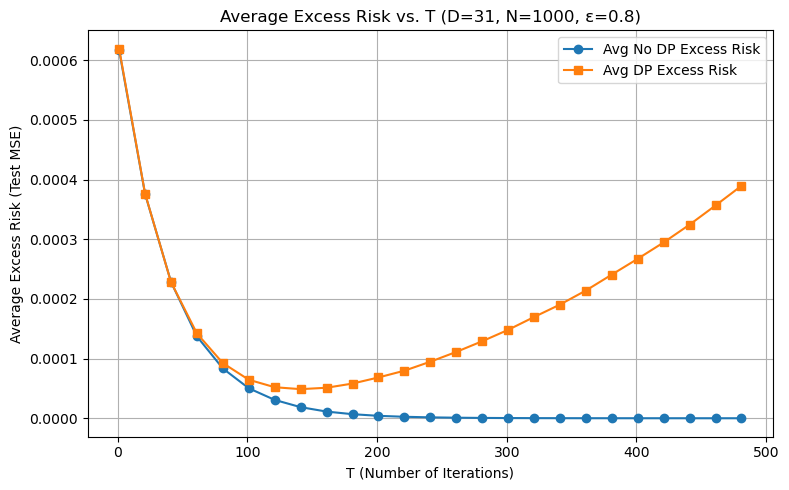

In [ ]:
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
import numpy as np

# Set consistent seed
np.random.seed(1609)

# Config
n_simulations = 500
n_jobs = 4
T_values = list(range(1, 500, 20))  # Keep T_values as in your original code

# Wrapper to run a single simulation with seed control
def single_run(seed, D, T_values):
    np.random.seed(seed)
    return run_experiment(D, T_values)

# Wrapper to run n_simulations and return average results in (D): (no_dp_avg, dp_avg) format
def run_experiment_wrapper(D):
    seeds = range(n_simulations)
    with tqdm_joblib(tqdm(desc=f"Running {n_simulations} simulations for D={D}", total=n_simulations, ncols=100)):
        results = Parallel(n_jobs=n_jobs)(
            delayed(single_run)(seed, D, T_values) for seed in seeds
        )

    # Average results across simulations
    no_dp_all = np.array([r[0] for r in results])
    dp_all = np.array([r[1] for r in results])
    no_dp_mean = np.mean(no_dp_all, axis=0)
    dp_mean = np.mean(dp_all, axis=0)
    return D, (no_dp_mean, dp_mean)

# Run one experiment (you can scale this for multiple D if needed)
results = [run_experiment_wrapper(int(1*np.sqrt(N)))]


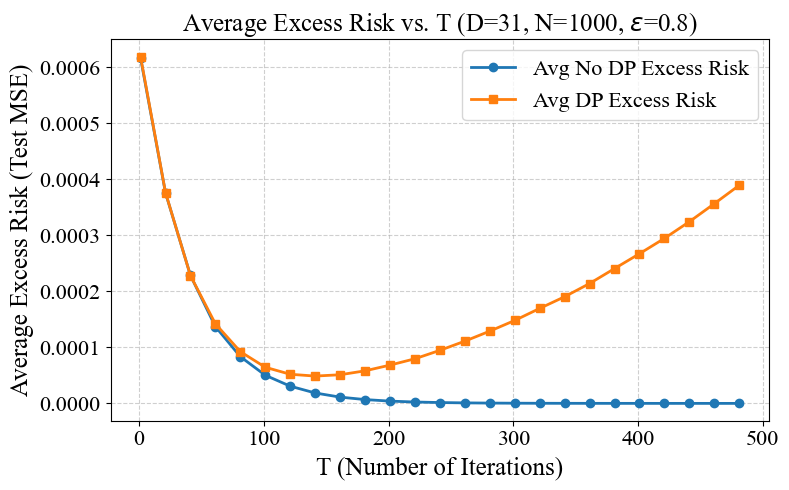

In [20]:
# Collect into a dictionary
results_dict = dict(results)

# Extract for given D
records = []

for D, (no_dp_arr, dp_arr) in results_dict.items():
    for t, no_dp, dp in zip(T_values, no_dp_arr, dp_arr):
        records.append({
            "D": D,
            "T": t,
            "avg_no_dp_excess": no_dp,
            "avg_dp_excess": dp
        })

df = pd.DataFrame(records)

# Save to CSV
df.to_csv("avg_excess_risk_vs_T.csv", index=False)

# Example: plotting the results
avg_no_dp_excess, avg_dp_excess = results_dict[int(1*np.sqrt(N))]

import matplotlib.pyplot as plt

# Use your plot styling
set_plot_style(use_tex=False)

# Create the figure with your standard size
create_figure(figsize=(8, 5))

# Plotting
plt.plot(T_values, avg_no_dp_excess, 'o-', label="Avg No DP Excess Risk")
plt.plot(T_values, avg_dp_excess, 's-', label="Avg DP Excess Risk")
plt.xlabel("T (Number of Iterations)")
plt.ylabel("Average Excess Risk (Test MSE)")
plt.title(f"Average Excess Risk vs. T (D={int(np.sqrt(N))}, N={N}, $\\varepsilon$=0.8)")
plt.legend()

# Save figure
save_figure("avg_excess_risk_vs_T.png", dpi=300)

# Show plot (optional)
plt.show()


In [13]:
results_dict

{31: (array([6.16770712e-04, 3.75915058e-04, 2.28488053e-04, 1.37102327e-04,
         8.34053362e-05, 5.02351823e-05, 3.07283549e-05, 1.85864678e-05,
         1.11895428e-05, 6.81576929e-06, 4.05516198e-06, 2.47780662e-06,
         1.49972917e-06, 9.13397389e-07, 5.51234916e-07, 3.37583020e-07,
         2.02816497e-07, 1.23007044e-07, 7.42650036e-08, 4.50903207e-08,
         2.71664222e-08, 1.65272456e-08, 9.99751910e-09, 6.09229090e-09,
         3.67984426e-09]),
  array([6.19012994e-04, 3.76440333e-04, 2.28152543e-04, 1.42056416e-04,
         9.23802876e-05, 6.45174179e-05, 5.19839086e-05, 4.87642449e-05,
         5.11280325e-05, 5.81286789e-05, 6.83512003e-05, 7.96802867e-05,
         9.47005402e-05, 1.11113806e-04, 1.29000932e-04, 1.48070844e-04,
         1.69583813e-04, 1.90434156e-04, 2.14010947e-04, 2.40678454e-04,
         2.67213280e-04, 2.94599220e-04, 3.24386070e-04, 3.56525981e-04,
         3.89434084e-04]))}

# Finer phase transition plot

1-eta0*lambda = 0.993770362353404
N = 1000
L = 31
D = 31
C = 4.547909955895627
R = 3.6417033187369414
G = 1.0546684692166761
sigma=17.69459397475098
lambda = 32.25806451612903
step-size = 0.00019311876704447458


Training: 100%|█████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.26it/s]


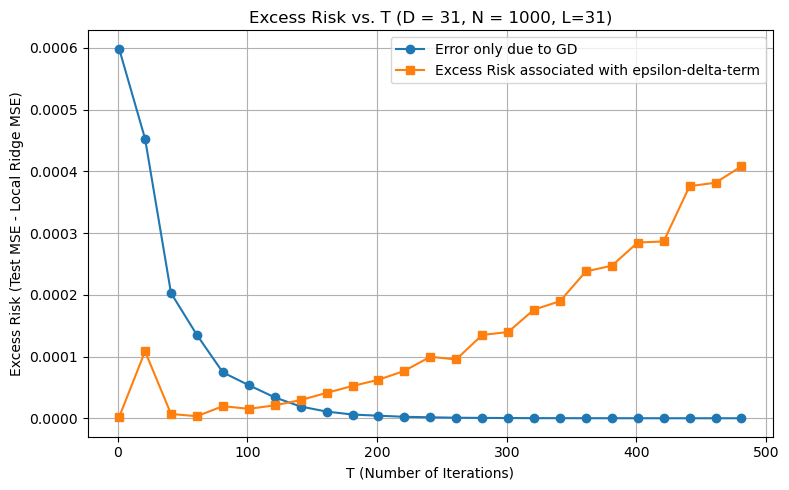

In [6]:
## decompose DP error =GD error+ extra error solely due to privacy

def run_experiment_decomp(D, T_values):
    """
    For each T value, train Algorithm 2 (both DP and non-DP) on a fixed training set,
    compute the local ridge oracle (using ridge regression on the training summary statistics)
    and then compute the excess risk (test MSE difference) between Algorithm 2 and the local ridge oracle.
    
    Returns:
      - no_dp_excess_risk: list of excess risks (non-DP) for each T.
      - dp_excess_risk: list of excess risks (DP) for each T.
    """
    # Parameters that depend on N, L, and D.
    lam = N/D  # Regularization parameter for both Algorithm 2 and ridge oracle.
    C = np.sqrt(2 * np.log(N * L))
    R = (1 / lam) * (C ** 2) * np.sqrt(N / L)
    G = (C / np.sqrt(L)) * (1 + (np.log(N) / (D ** 2)) ** (1 / 4))
    eta0 = 0.01*(2 * lam / (3 * ((lam + G ** 2) ** 2)))
    
    print(f"1-eta0*lambda = {(1-eta0*lam)}")
    print(f"N = {N}")
    print(f"L = {L}")
    print(f"D = {D}")
    print(f"C = {C}")
    print(f"R = {R}")
    print(f"G = {G}")
    print(f"sigma={2.0 * G * (C + R * G)}")
    print(f"lambda = {lam}")
    print(f"step-size = {eta0}")
    
    no_dp_excess_risk = []
    dp_excess_risk = []
    
    for T in tqdm(T_values, desc="Training", ncols=100, position=0):
        # Build the training dataset.
        xs_train, xq_train, ys_train, yq_train = build_dataset(N, D, L)
        # Build a test dataset.
        N_test = 500
        xs_test, xq_test, ys_test, yq_test = build_dataset(N_test, D, L)
        
        # Train Algorithm 2 (non-DP) on the same training data.
        losses_no_dp, Gamma_no_dp, Ztilde_ls, _ = train_algorithm2(
            xs_train, xq_train, ys_train, yq_train,
            D, N, L,
            C, R, G, lam, eta0, T,
            epsilon, delta,
            sigma_multiplier, dp_enabled=False
        )
        # Train Algorithm 2 (DP) on the same training data.
        losses_dp, Gamma_dp, _, _ = train_algorithm2(
            xs_train, xq_train, ys_train, yq_train,
            D, N, L,
            C, R, G, lam, eta0, T,
            epsilon, delta,
            sigma_multiplier, dp_enabled=True
        )
        
        # --- Compute the local ridge oracle on the training set ---
        # Reshape the summary statistics from non-DP training.
        N_train = N
        d1, d2 = Ztilde_ls.shape[1:3]
        D_total = d1 * d2
        Zmat = Ztilde_ls.reshape(N_train, D_total)
        ridge_lam = lam  # Use the same regularization parameter.
        A = (N_train * ridge_lam) * np.eye(D_total) + Zmat.T @ Zmat
        b = Zmat.T @ yq_train
        L_chol = np.linalg.cholesky(A)
        v = np.linalg.solve(L_chol, b)
        gamma_vec = np.linalg.solve(L_chol.T, v)
        Gamma_star = gamma_vec.reshape(d1, d2)
        
        # --- Compute test predictions ---
        Z_test_all = compute_Ztilde_vectorized(xq_test, xs_test, ys_test, L, G, C, dp_enabled=False)
        # Local ridge predictions.
        y_hat_ridge = np.sum(Gamma_star * Z_test_all, axis=(1,2))
        mse_ridge = np.mean((y_hat_ridge - yq_test)**2)
        
        # Algorithm 2 predictions.
        #Z_tilde_test = compute_Ztilde(xq_test[k], xs_test[k], ys_test[k],
                                          #L, G, C, dp_enabled=True)
        #y_hat_no_dp = np.sum(Gamma_no_noise * Z_tilde_test)
        #y_hat_dp    = np.sum(Gamma_dp      * Z_tilde_test)
        y_hat_no_dp = np.sum(Gamma_no_dp * Z_test_all, axis=(1,2))
        mse_no_dp = np.mean((y_hat_no_dp - y_hat_ridge)**2)
        
        y_hat_dp = np.sum(Gamma_dp * Z_test_all, axis=(1,2))
        mse_dp = np.mean((y_hat_dp - y_hat_ridge)**2)
        
        # Compute excess risk as the difference from the local ridge oracle.
        excess_risk_no_dp = mse_no_dp # find the error only due to DP term.
        excess_risk_dp = abs(mse_dp - mse_no_dp) # find the error only due to DP term.
        
        no_dp_excess_risk.append(excess_risk_no_dp)
        dp_excess_risk.append(excess_risk_dp)
        
    return no_dp_excess_risk, dp_excess_risk

# Define T values: 1, 20, ..., 100.
T_values = list(range(1, 500, 20))

######################################
# Run Experiments for Two Settings of D
######################################
# Case 1: D = 5
#no_dp_excess_D5, dp_excess_D5 = run_experiment(5, T_values)
# Case 2: D ≈ √N;
#no_dp_excess_D32, dp_excess_D32 = run_experiment_decomp(int(1*N**0.5), T_values)

######################################
# Plotting the Results
######################################
# Plot for D = 5.
#plt.figure(figsize=(8, 5))
#plt.plot(T_values, no_dp_excess_D5, 'o-', label="No DP Excess Risk")
#plt.plot(T_values, dp_excess_D5, 's-', label="DP Excess Risk")
#plt.xlabel("T (Number of Iterations)")
#plt.ylabel("Excess Risk (Test MSE - Local Ridge MSE)")
#plt.title("Excess Risk vs. T (D = 5, N = 8000, ε = 0.05)")
#plt.legend()
#plt.grid(True)
#plt.tight_layout()
#plt.show()

# Plot for D = sqrt(N).



In [ ]:
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for consistency
np.random.seed(1609)

# Constants
n_simulations = 500
n_jobs = 4
T_values = list(range(1, 500, 20))
D = int(1 * N**0.5)  # Do not change

# Single run wrapper with seeding
def single_run_decomp(seed, D, T_values):
    np.random.seed(seed)
    return run_experiment_decomp(D, T_values)

# Wrapper to run multiple simulations and return (D): (GD_error, DP_extra_error)
def run_experiment_decomp_wrapper(D):
    seeds = range(n_simulations)
    with tqdm_joblib(tqdm(desc=f"Running {n_simulations} decomposed sims for D={D}", total=n_simulations, ncols=100)):
        results = Parallel(n_jobs=n_jobs)(
            delayed(single_run_decomp)(seed, D, T_values) for seed in seeds
        )

    # Average results across simulations
    no_dp_all = np.array([res[0] for res in results])
    dp_all = np.array([res[1] for res in results])
    no_dp_mean = np.mean(no_dp_all, axis=0)
    dp_mean = np.mean(dp_all, axis=0)
    return D, (no_dp_mean, dp_mean)

# Run the simulation
results = [run_experiment_decomp_wrapper(D)]

# Unpack results
results_dict = dict(results)
avg_gd_error, avg_dp_extra_error = results_dict[D]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(T_values, avg_gd_error, 'o-', label="Error only due to GD")
plt.plot(T_values, avg_dp_extra_error, 's-', label="Excess Risk associated with ε-δ term")
plt.xlabel("T (Number of Iterations)")
plt.ylabel("Excess Risk (Test MSE - Local Ridge MSE)")
plt.title("Excess Risk vs. T (D = √N, N = 8000)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
